In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [35]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size) ** 0.5) # Kaiming initialization
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # because of bnbias, b1 is wasteful
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

#std = (gain/ root of fanin), gain is specail constant for each activation functions
#for w1; std = (5/3) / ((n_embd * block_size) ** 0.5)

parameters = [C, W1,  W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [47]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [48]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [36]:
# same optimization as last time

max_steps = 200000
batch_size = 32
lossi = []

for i in range (max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view (emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1  # +  b1 # hidden layer pre-activation

    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh (hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy (logits, Yb) # loss function
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    if i % 10000 == 0: # print every once in a while
        print (f' {i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    #break

       0/ 200000: 3.3147
   10000/ 200000: 2.1984
   20000/ 200000: 2.3375
   30000/ 200000: 2.4359
   40000/ 200000: 2.0119
   50000/ 200000: 2.2595
   60000/ 200000: 2.4775
   70000/ 200000: 2.1020
   80000/ 200000: 2.2788
   90000/ 200000: 2.1862
  100000/ 200000: 1.9474
  110000/ 200000: 2.3010
  120000/ 200000: 1.9837
  130000/ 200000: 2.4523
  140000/ 200000: 2.3839
  150000/ 200000: 2.1987
  160000/ 200000: 1.9733
  170000/ 200000: 1.8668
  180000/ 200000: 1.9973
  190000/ 200000: 1.8347


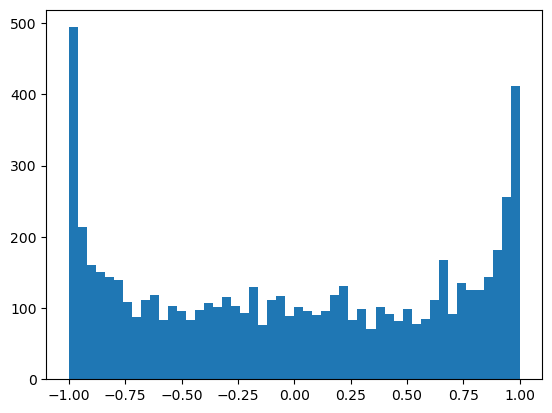

In [26]:
plt.hist(h.view(-1).tolist(), 50); #distributions of tanh activation

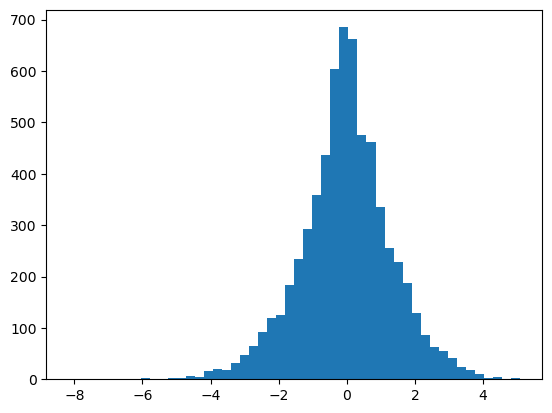

In [27]:
plt.hist(hpreact.view(-1).tolist(), 50); #distributions of hpreact

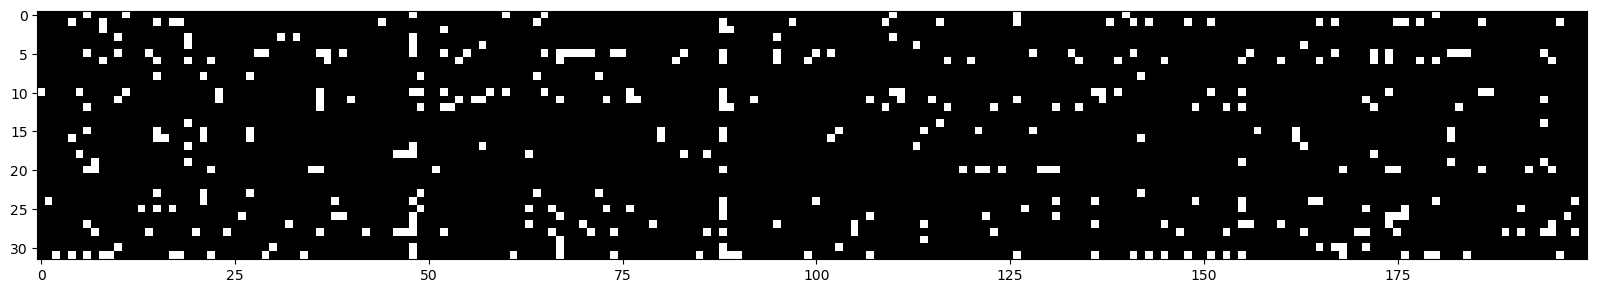

In [28]:
plt.figure(figsize=(20, 40))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation = 'nearest')
#If any column is whole white then it called "a dead neuron"

In [ ]:
logits = torch.tensor([0.0, 0.0, 3.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

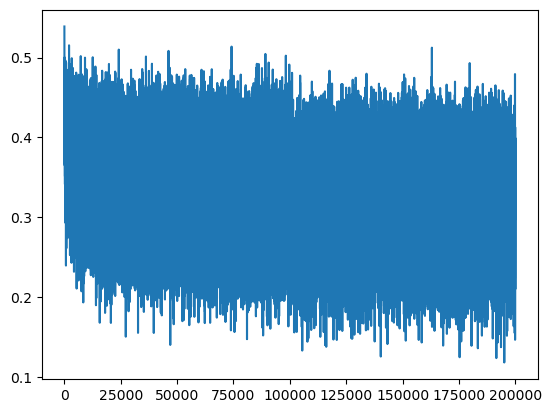

In [29]:
plt.plot(lossi)

In [30]:
# calibrate batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    

In [31]:
bnmean

tensor([[-2.7958e+00,  7.1048e-01, -8.7686e-01,  9.2298e-01,  1.3306e+00,
          1.6343e+00,  2.6635e+00, -1.8416e+00,  5.9183e-01,  1.3132e+00,
         -2.1547e+00, -2.6044e+00, -8.1745e-01, -3.3151e-01, -4.2749e-01,
          6.8339e-02,  1.3182e+00, -2.8981e+00, -6.1827e-01,  1.5721e+00,
         -8.6524e-01, -6.5405e-02,  4.8284e-01,  7.7396e-01,  1.8665e+00,
         -1.1199e+00,  1.9443e+00,  8.1121e-01, -1.5757e-01,  2.5053e+00,
         -5.3651e-02, -1.3597e+00, -1.0319e+00,  4.1389e-02,  1.8747e-01,
         -6.9674e-01, -9.2941e-01,  1.9096e-01, -1.1103e+00,  1.0725e+00,
         -1.0264e+00, -1.1938e+00, -8.3321e-01, -4.1362e-01,  9.9160e-01,
          2.8802e-01,  1.4563e+00, -1.1433e+00,  2.5001e+00,  1.2986e+00,
          2.8408e-01,  3.9376e-01,  2.4543e+00,  7.9602e-01,  2.4005e-01,
         -2.2163e+00,  1.7907e-01,  3.6883e-01,  1.1897e+00, -1.9102e+00,
         -8.6507e-01,  9.8304e-01,  2.0370e-01,  5.8984e-01,  1.7883e+00,
          1.1460e+00, -1.0143e+00,  1.

In [32]:
bnmean_running

tensor([[-2.8112,  0.7182, -0.8691,  0.9296,  1.3394,  1.6281,  2.6612, -1.8544,
          0.5801,  1.2969, -2.1676, -2.6183, -0.8187, -0.3381, -0.4243,  0.0876,
          1.3321, -2.9077, -0.6389,  1.5570, -0.8616, -0.0426,  0.4678,  0.7803,
          1.8660, -1.1145,  1.9580,  0.8101, -0.1598,  2.5125, -0.0630, -1.3626,
         -1.0307,  0.0431,  0.1956, -0.6980, -0.9311,  0.1784, -1.0972,  1.0787,
         -1.0323, -1.2147, -0.8338, -0.4174,  0.9993,  0.2980,  1.4657, -1.1557,
          2.4847,  1.2882,  0.2677,  0.3829,  2.4507,  0.8068,  0.2489, -2.2182,
          0.1760,  0.3660,  1.1983, -1.9198, -0.8762,  0.9779,  0.1939,  0.5818,
          1.7871,  1.1426, -1.0229,  1.6389, -1.0793,  0.0613,  0.0696,  0.5413,
          1.2133, -1.6766, -2.9116,  0.1123,  0.9743,  0.2854,  0.6263,  0.3937,
          0.1164,  1.4464,  1.9855,  0.9231,  1.0525, -0.3981, -2.4829,  0.3153,
          2.4056,  0.1535, -1.7000,  1.0114, -0.6635, -0.9832, -0.5597,  0.6826,
         -0.0358, -0.5193, -

In [33]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss (split):
    x, y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    } [split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view (emb.shape[0], -1) # concat into (N, block_size* n_embd)
    hpreact = embcat @ W1 
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden) 
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy (logits, y)
    print (split, loss.item())
split_loss('train')
split_loss('val')

train 2.067103624343872
val 2.1081297397613525


In [34]:
# sample from the model
g = torch.Generator().manual_seed (2147483647 + 10)
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch. tensor ( [context])] # (1,block_size,n_embd)
        h = torch.tanh (emb.view(1, -1) @ W1 + b1 )
        logits = h @ W2 + b2
        probs = F.softmax (logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial (probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)) # decode and print the generated word

brithl.
sadlizelmadhahmmarzisrngeld.
qie.
szeerdne.
klusspprenriksissanghannyxtzishmyasnnjshdunrgahghnnstke.
jownllvinnchusfcurmarvellyasqufmergylversseffydiahnl.
sadya.
suftzalklubusslytry.
ksvelleggprvdnn.
qyenexphmbpeilcormtyzlavhanvollisaqiincerphswnllamittasstviktegsisssmaizbaklvissirvellennrketzullysxavonndkosbiennccaldmotgttai.
bdylhavirlquijaskparguislr.
klyamiizsskloniellahnnylvikshlyyanshnvarcerzabrkkenzjaythn.
jamellesslannviggdrviktnatguem.
cannibsllvinhtanmosswuscaldordnkarpokspopplmnenlysshfalrxesskfiunssrighansh.
ksabic.
clustancssnd.
khimmarnahlynnakhlembegghisslavonnixzck.
xayrssellus.
qienlixsadlfgirtxleerpie.
qeeladia.
